In [1]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import scipy
import pandas as pd
import pickle
import scipy.stats
from ipyparallel import Client
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rc = Client()

In [3]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [4]:
def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

In [5]:
def compute_inv_shrunk_covariance(x,mask):
    #see http://www.diedrichsenlab.org/pubs/Walther_Neuroimage_2016.pdf
    t,n = x.shape #t measurements by n voxels

    #demean
    x = x - x.mean(0)

    #compute covariance
    sample = (1.0/t) * np.dot(np.transpose(x),x)

    #copute prior
    prior = np.diag(np.diag(sample))

    #compute shrinkage
    d = 1.0/n * np.linalg.norm(sample - prior,ord = 'fro')**2
    y = np.square(x)
    r2 = 1.0/n/t**2 * np.sum(np.sum(np.dot(np.transpose(y),y)))- \
    1.0/n/t*np.sum(np.sum(np.square(sample)))

    #compute the estimator
    shrinkage = max(0,min(1,r2/d))
    sigma = shrinkage*prior + (1-shrinkage)*sample

    #compute the inverse
    if is_invertible(sigma) or mask != 'VTC_sim':
        inv_sigma = np.linalg.inv(sigma)
    else:
        inv_sigma = np.linalg.inv(prior) #univariate
    
    return inv_sigma

In [6]:
#make sure MTL masks are exclusive
def trim_mask(sub,mask,m):
    exclusions = overlap_masks[:]
    exclusions.remove(m)

    m1 = op.join(home_dir,'data', sub,  'masks', exclusions[0] +'.nii.gz')
    m1 = nib.load(m1).get_data().astype(bool)

    m2 = op.join(home_dir,'data', sub,  'masks', exclusions[1] +'.nii.gz')
    m2 = nib.load(m2).get_data().astype(bool)

    bad = np.logical_or(m1,m1)
    good = np.invert(bad)

    mask = np.logical_and(mask,good)
    return mask

In [7]:
def compute_inverse_sigma(sub,exp,smooth,masks):
    sub_path = op.join(home_dir,'analysis', exp, sub, 'reg','epi', smooth)
    for run in map(str,range(1,4)):
        res = op.join(sub_path, 'run_'  + run,'res4d_xfm.nii.gz')
        
        if op.exists(res):
            res = nib.load(res).get_data().astype(float)

            for m in masks:
                out_f = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')
                
                if not op.exists(out_f): #don't recompute
                    mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
                    mask = nib.load(mask).get_data().astype(bool)
                    if m in overlap_masks:
                        mask = trim_mask(sub,mask,m)

                    x = res[mask]
                    x = np.transpose(x)

                    inv_sigma = compute_inv_shrunk_covariance(x,m)

                    inv_sigma = scipy.linalg.fractional_matrix_power(inv_sigma,.5) #take square root

                    np.savetxt(out_f,inv_sigma)

In [8]:
def delete_inverse_sigma(sub,exp,smooth,masks):
    for run in map(str,range(1,4)):
        for m in masks:
            out_f = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')
            if op.exists(out_f):
                os.remove(out_f)

In [9]:
def get_condition(i,single):
    if single:
        return cond_map[i], 1
    elif i < 11:
        cond = 'b_plus'
        trial = i
    elif i < 21:
        cond = 'c_plus'
        trial = i - 10
    elif i < 31:
        cond = 'c_minus'
        trial = i - 20
    elif i < 41:
        cond = 'b_minus'
        trial = i - 30
    return cond,trial

In [10]:
def extract_betas(sub,exp,smooth,masks,single = True):
    if single:
        nbetas = 4
    else:
        nbetas = 40
        exp_id = 'sim_4mm-betas'
            
    all_betas = []
    for m in masks:
        out_f = op.join(home_dir,'betas', '_'.join([exp_id,sub,smooth,m]) + '.csv')
        
        #extract saved betas
        if not op.exists(out_f):
            betas = {'sub':[],'mask':[],'run':[],'condition':[],'value':[],'trial':[],'voxel':[],'row':[]}
            sub_path = op.join(home_dir,'analysis', exp_id, sub, 'reg','epi', smooth )

            mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
            mask = nib.load(mask).get_data().astype(bool)
            if m in overlap_masks:
                mask = trim_mask(sub,mask,m)


            for run in map(str,range(1,4)):
                run_dir = op.join(sub_path, 'run_'  + run)

                if os.path.exists(run_dir):

                    for i in range(1,nbetas + 1):
                        f = run_dir + '/cope' + str(i) + '_xfm.nii.gz'

                        cond, trial = get_condition(i,single)

                        #load stat image
                        stat = nib.load(f).get_data().astype(float)
                        stat = stat[mask]

                        for n,val in enumerate(stat):
                            betas['voxel'].append(n)                        
                            betas['sub'].append(sub)
                            betas['value'].append(val)
                            betas['mask'].append(m)
                            betas['run'].append(run)
                            betas['condition'].append(cond)
                            betas['trial'].append(trial)
                            betas['row'].append(i)
                else:
                    print run_dir

            betas = pd.DataFrame(betas)
            betas.to_csv(out_f,index = False)
            
        else: #load from disk
            betas = pd.read_csv(out_f)
            
        all_betas.append(betas)
    all_betas = pd.concat(all_betas)
    all_betas = all_betas.set_index(['sub', 'run','mask','condition','trial'])
    return all_betas

In [11]:
def prewhiten_betas(old_betas,sub,exp,smooth,masks,single = True):
    
    all_betas = []
    if not single:
        exp_id = 'sim_4mm-betas'
        
    for m in masks:
        out_f = op.join(home_dir,'betas', 'whitened','_'.join([exp_id,sub,smooth,m]) + '.csv')
        
        if op.exists(out_f):
            all_betas.append(pd.read_csv(out_f))
            
        else:
            betas = old_betas.xs(m, level='mask', axis=0)
            
            for run in map(str,range(1,4)):
                #load covariance
                inv_sigma = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')

                if op.exists(inv_sigma):
                    inv_sigma = np.loadtxt(inv_sigma)

                    for cond in conds:
                        for trial in range(1,11):
                            vals = betas.loc[(sub,int(run),cond,trial),'value'].values
                            whiten_vals = np.dot(vals,inv_sigma)
                            betas.loc[(sub,int(run),cond,trial),'value'] = whiten_vals
                else:
                    print 'no covariance file',inv_sigma
                    
            out_betas = pd.DataFrame(betas.to_records()) 
            out_betas['mask'] = m
            out_betas.to_csv(out_f,index = False)
            all_betas.append(out_betas)
        
    all_betas = pd.concat(all_betas)
    all_betas = all_betas.set_index(['sub', 'run','mask','condition','trial'])
    return all_betas

In [12]:
# def compute_rsa(sub,exp,masks,betas):
#     rsas = {}
#     for m in masks:
        
#         runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index)))
#         nruns = len(runs)
#         rsa = np.zeros((nconds,nconds))

#         for i in range(1,nconds+1):
#             for j in range(1,nconds+1):
#                 corr = []
                
#                 corr.append(scipy.stats.pearsonr(betas.loc[(sub,'1',m,cond_map[i]),'value'].values,
#                                      betas.loc[(sub,'2',m,cond_map[j]),'value'].values))
#                 if i != j:
#                     corr.append(scipy.stats.pearsonr(betas.loc[(sub,'2',m,cond_map[i]),'value'].values,
#                                          betas.loc[(sub,'1',m,cond_map[j]),'value'].values))

#                 if nruns == 3:

#                     corr.append(scipy.stats.pearsonr(betas.loc[(sub,'1',m,cond_map[i]),'value'].values,
#                                          betas.loc[(sub,'3',m,cond_map[j]),'value'].values))
#                     corr.append(scipy.stats.pearsonr(betas.loc[(sub,'2',m,cond_map[i]),'value'].values,
#                                          betas.loc[(sub,'3',m,cond_map[j]),'value'].values))
#                     if i != j:
#                         corr.append(scipy.stats.pearsonr(betas.loc[(sub,'3',m,cond_map[i]),'value'].values,
#                                                          betas.loc[(sub,'1',m,cond_map[j]),'value'].values))
#                         corr.append(scipy.stats.pearsonr(betas.loc[(sub,'3',m,cond_map[i]),'value'].values,
#                                                          betas.loc[(sub,'2',m,cond_map[j]),'value'].values))
                       
#                 rsa[i-1,j-1]  = np.nanmean(corr)
#         rsas[m] = rsa
        
#     return rsas

In [12]:
def compute_rsa_onebeta(sub,exp,masks,betas):
    rsas = {}
    for m in masks:
        
        runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index)))
        nruns = len(runs)
        rsa = np.zeros((nconds,nconds))

        for i in range(1,nconds+1):
            for j in range(1,nconds+1):
                corr = []
                
                corr.append(scipy.stats.pearsonr(betas.loc[(sub,1,m,cond_map[i]),'value'].values,
                                                 betas.loc[(sub,1,m,cond_map[j]),'value'].values))
                corr.append(scipy.stats.pearsonr(betas.loc[(sub,2,m,cond_map[i]),'value'].values,
                                                 betas.loc[(sub,2,m,cond_map[j]),'value'].values))

                if nruns == 3:

                    corr.append(scipy.stats.pearsonr(betas.loc[(sub,3,m,cond_map[i]),'value'].values,
                                                     betas.loc[(sub,3,m,cond_map[j]),'value'].values))
                       
                rsa[i-1,j-1]  = np.nanmean(corr)
        rsas[m] = rsa
        
    return rsas

In [13]:
def compute_rsa_betas(sub,exp,masks,betas):
    rsa_df = {'cond1':[],'cond2':[],'corr':[],'mask':[],'run':[],'sub':[]}
    runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index))) #get runs
    
    for m in masks:
        
        for i in range(1,nconds+1):
            for j in range(1,nconds+1):
                
                if i<= j:
                    for trial1 in range(1,11):
                        for trial2 in range(1,11):

                            if i !=j or trial1 < trial2:
                                for run in runs:
                                    r = scipy.stats.pearsonr(betas.loc[(sub,run,m,cond_map[i],trial1),'value'].values,
                                                                 betas.loc[(sub,run,m,cond_map[j],trial2),'value'].values)[0]

                                    rsa_df['mask'].append(m)
                                    rsa_df['sub'].append(sub)
                                    rsa_df['cond1'].append(name_map[cond_map[i]] + str(trial1-1))
                                    rsa_df['cond2'].append(name_map[cond_map[j]] + str(trial2-1))
                                    rsa_df['corr'].append(r)        
                                    rsa_df['run'].append(run)        
    return pd.DataFrame(rsa_df)

In [14]:
def compute_rsa_euclid(sub,exp,masks,betas):
    rsas = {}
    for m in masks:
        
        #Get crossval folds. Deal with unequal number of runs across subjects
        runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index)))
        nruns = len(runs)
        if nruns == 3:
            train_runs = [['1','2'],['1','3'],['2','3']]
        elif nruns == 2:
            train_runs = [['1'],['2']]
        
        rsa = np.zeros((4,4,len(runs)))

        #loop through condition pairs
        for i in range(1,rsa.shape[0]+1):
            for j in range(1,rsa.shape[0]+1):
                if j < i:
                    #get euclidian distance between conditions for each run
                    run_euclid_dist = {}
                    for run in map(str,range(1,nruns+1)):
                        
                        cond1 = betas.loc[(sub,run,m,cond_map[i]),'value'].values
                        cond2 = betas.loc[(sub,run,m,cond_map[j]),'value'].values
                        
                        run_euclid_dist[run] = cond1 - cond2
                    
                    #do cross-validation
                    for n,train_run in enumerate(train_runs):
                        train_vector = []
                        test_vector = []
                    
                        for run in map(str,range(1,nruns+1)): 
                            if run in train_run:
                                train_vector.append(run_euclid_dist[run])
                            else:
                                test_vector.append(run_euclid_dist[run])

                        train_vector = np.mean(train_vector,0)
                        test_vector = np.mean(test_vector,0)
                        
                        diff = np.dot(train_vector,test_vector)
                        
                        rsa[i-1,j-1,n] = diff
        rsa = rsa.mean(2)
        rsas[m] = rsa
    return rsas

In [708]:
def run_sub(sub):
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim_unwhitened.pkl')

    if True:#not op.exists(out_f):

#         compute_inverse_sigma(sub,exp,smooth,masks)
        betas = extract_betas(sub,exp,smooth,masks,False)
#         betas = prewhiten_betas(betas,sub,exp,smooth,masks,False)
#         delete_inverse_sigma(sub,exp,smooth,masks) #save disk space

        rsas = compute_rsa_betas(sub,exp,masks,betas)

        #write rsa to a file in case we have to stop the script
        output = open(out_f, 'wb')
        pickle.dump(rsas, output)
        output.close()  

In [709]:
masks = ['yeo17_ifs','mOFC_fill_sim','hipp','hipp_right','hipp_left',
         'entorhinal','peri_sim','para_sim',]
overlap_masks = ['peri_sim','para_sim','hipp']
masks = ['yeo17_ifs','mOFC_fill_sim','hipp','peri_sim','para_sim']
exp = 'sim_4mm-onebeta'
smooth = 'smoothed'
conds = ['b_plus','b_minus','c_plus','c_minus']
name_map = {'b_plus':'AB+_', 'c_minus':'AC-_','b_minus':'B-_','c_plus':'C+_'}
cond_map = {1:'b_plus',2:'c_minus',3:'b_minus',4:'c_plus'}
nconds = len(cond_map.keys())

# masks = ['hipp']
# run_sub('fd_104')

In [710]:
dview = rc[0:33]
dview.block = True

dview.push(dict(home_dir=home_dir,
                masks = masks,
                exp = exp,
                conds = conds,
                smooth = smooth,
                cond_map = cond_map,
                name_map = name_map,
                nconds = nconds,
                get_condition = get_condition,
                overlap_masks = overlap_masks,
                prewhiten_betas = prewhiten_betas,
                compute_inv_shrunk_covariance = compute_inv_shrunk_covariance,
                compute_inverse_sigma = compute_inverse_sigma,
                is_invertible = is_invertible,
                extract_betas = extract_betas,
                delete_inverse_sigma = delete_inverse_sigma,
                trim_mask = trim_mask,
                compute_rsa_euclid = compute_rsa_euclid,
                compute_rsa_betas = compute_rsa_betas
                ))
dview.execute("import numpy as np")
dview.execute("import os.path as op")
dview.execute("import nibabel as nib")
dview.execute("import pandas as pd")
with dview.sync_imports():
    import os
    import numpy
    import scipy
    import scipy.stats
    import pickle
dview.map_sync(run_sub,subs)

importing os on engine(s)
importing numpy on engine(s)
importing scipy on engine(s)
importing scipy.stats on engine(s)
importing pickle on engine(s)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [797]:
#load RSAs from disk
all_rsas = []
for sub in subs:
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim.pkl')
    pkl_file = open(out_f, 'rb')
    rsa = pickle.load(pkl_file)
    all_rsas.append(rsa)
all_rsas = pd.concat(all_rsas)

In [798]:
#add in diagonal elements
new_df = pd.DataFrame()
for sub in subs:
    runs = set(all_rsas.loc[all_rsas['sub'] == sub,'run'])
    for m in masks:
        for run in runs:
            for cond in ['AB+_','B-_','AC-_','C+_']:
                for i in range(10):
                    row = pd.DataFrame({'mask':m,
                                       'sub':sub,
                                        'run':run,
                                        'cond1':cond + str(i),
                                        'cond2':cond + str(i),
                                        'corr': 1.0}, index = [0])
                    new_df = new_df.append(row)
fig_rsas = pd.concat([all_rsas, new_df])

In [799]:
fig_rsas = fig_rsas.set_index(['mask','run','sub'])

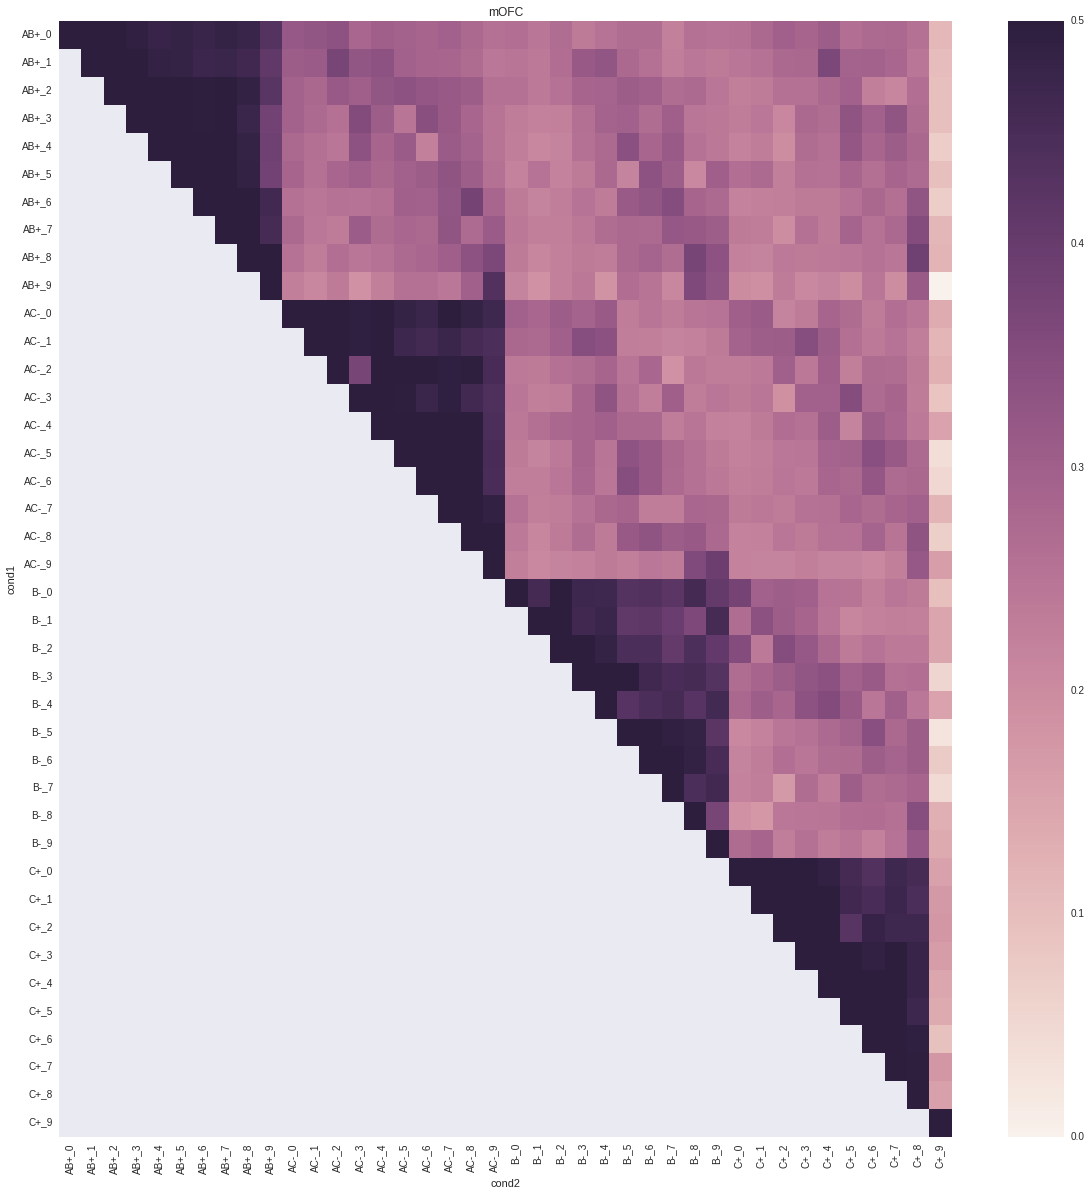

In [803]:
sns.set(rc={"figure.figsize": (20, 20)})
mean_rsa = fig_rsas.loc['hipp',1].groupby(['cond1','cond2']).mean()
mean_rsa = mean_rsa.unstack()['corr']
sns.heatmap(mean_rsa, vmin = 0, vmax= .5)
plt.title('mOFC')
plt.savefig('/home/iballard/Dropbox/fd/figs/mOFC_RSA.png')

In [839]:
RL_std = pd.read_csv('/home/iballard/fdPE_V.csv')
RL_std = RL_std[RL_std['condition'] != 'feedback']
RL_std = RL_std.set_index(['exp','sub','run','condition'])
RL_std = RL_std.loc[('sim','fd_104')]

In [840]:
def get_base_model(sub,mask): 
    reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

    overlap_pairs = [['b_plus','b_minus'],
                    ['c_plus','c_minus'],
                    ['b_plus','c_minus']]
    overlap_pairs = [set(x) for x in overlap_pairs] #so order doesnt matter

    not_overlap_pairs = [['b_plus','c_plus'],
                     ['c_plus','b_minus'],
                      ['c_minus','b_minus']]
    not_overlap_pairs = [set(x) for x in not_overlap_pairs] #so order doesnt matter

    within_context_pairs = [['b_plus','c_minus'],
                           ['b_minus','c_plus']]
    within_context_pairs = [set(x) for x in within_context_pairs] #so order doesnt matter

    between_context_pairs = [['b_plus','b_minus'],
                            ['c_plus','c_minus'],
                            ['b_plus','c_plus'],
                            ['c_minus','b_minus']]
    between_context_pairs = [set(x) for x in between_context_pairs] #so order doesnt matter

    pairs = ['b_pluszzzc_minus','b_pluszzzb_minus', 'c_pluszzzc_minus','c_pluszzzb_minus',
             'c_pluszzzb_plus','b_minuszzzc_minus']

    #get dataframe
    sub_rsa = all_rsas.set_index(['mask','sub','run'])
    sub_rsa = sub_rsa.loc[(mask,sub)]
    runs = set(sub_rsa.index)

    #initialize model
    model = {'response' : [],
    'valence' : [],
    'identity' : [],
    'time' : [],
    'overlap' : [],
    'context' : [],
    'value' : [],
    'pe':[],
    'run_idx' : [], 
    'corr' : [],
    'cond1':[],
    'cond2':[]}
    for i in range(10):
        model['overlap_' + str(i)] = []
    for pair in pairs:
        model[pair] = []

    for run in runs:
        for c1, c2, r in zip(sub_rsa.loc[run,'cond1'].values,
                             sub_rsa.loc[run,'cond2'].values,
                             sub_rsa.loc[run,'corr'].values):

            #get variables in tidy format
            cond1, trial1 = c1.split('_')
            cond2, trial2 = c2.split('_')
            cond1 = reverse_name_map[cond1]
            cond2 = reverse_name_map[cond2]

            #get reward codings
            r1 = RL_std.loc[(run,cond1),'rew'].values[trial1]
            r2 = RL_std.loc[(run,cond2),'rew'].values[trial2]
            same = int(r1 == r2)
            val = int(same)
            if r1 < 1.0:
                val = 0
            model['response'].append(same)
            model['valence'].append(val)

            ##each condition
            for pair in pairs:
                if set(pair.split('zzz')) == set([cond1,cond2]):
                    model[pair].append(1)
                else:
                    model[pair].append(0)


            ##identity
            iden= int(cond1 == cond2)
            model['identity'].append(iden)

            #time
            t = abs(int(trial1) - int(trial2))
            model['time'].append(t)

            #overlap
            ov = set([cond1,cond2]) in overlap_pairs
            non_ov = set([cond1,cond2]) in not_overlap_pairs
            for i in range(10):
                ov_trial = 0
                if ov and trial1 == trial2 and int(trial1) ==i:
                    ov_trial = 1
                elif non_ov and trial1 == trial2 and int(trial1) ==i:
                    ov_trial = -1
                model['overlap_' + str(i)].append(ov_trial)   
            model['overlap'].append(ov - non_ov)

            #context
            within = set([cond1,cond2]) in within_context_pairs
            between = set([cond1,cond2]) in between_context_pairs 
            model['context'].append(within - between)


            #value difference
            v1 = RL_std.loc[(run,cond1),'V'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'V'].values[trial2]
            vdiff = abs(v1 - v2)
            model['value'].append(vdiff)
            
            #PE difference
            v1 = RL_std.loc[(run,cond1),'PE'].values[trial1]
            v2 = RL_std.loc[(run,cond2),'PE'].values[trial2]
            vdiff = abs(v1 - v2)
            model['pe'].append(vdiff)
            model['pe_unsigned'].append(vdiff)
            
            #run
            model['run_idx'].append(run)

            #corr
            model['corr'].append(r)

            #cond labels
            model['cond1'].append(c1)
            model['cond2'].append(c2)

    model = pd.DataFrame(model)
    return model

In [841]:
base = get_base_model('fd_104','hipp')
mask_models={}
for mask in masks:
    all_models = {}

    for sub in subs:
        sub_rsa = all_rsas.set_index(['mask','sub','run'])
        sub_rsa = sub_rsa.loc[(mask,sub)]
        runs = sorted(set(sub_rsa.index))
        
        #deal with uneven number of runs
        base_runs = [1,2,3]
        sub_df = base.copy()
        if len(runs) != len(base_runs): #right number of runs
            bad_runs = set(runs) ^ set(base_runs)
            for bad_run in bad_runs:
                sub_df = sub_df[sub_df['run_idx'] != bad_run]
        all_models[sub] = sub_df

        corr = []
        for run in runs:
            r = sub_rsa.loc[run]['corr'].values
            corr.extend(r)
            
        all_models[sub]['corr'] = corr

    mask_models[mask] = dict(all_models)

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:106: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:112: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/iballard/anaconda/lib/python2.7

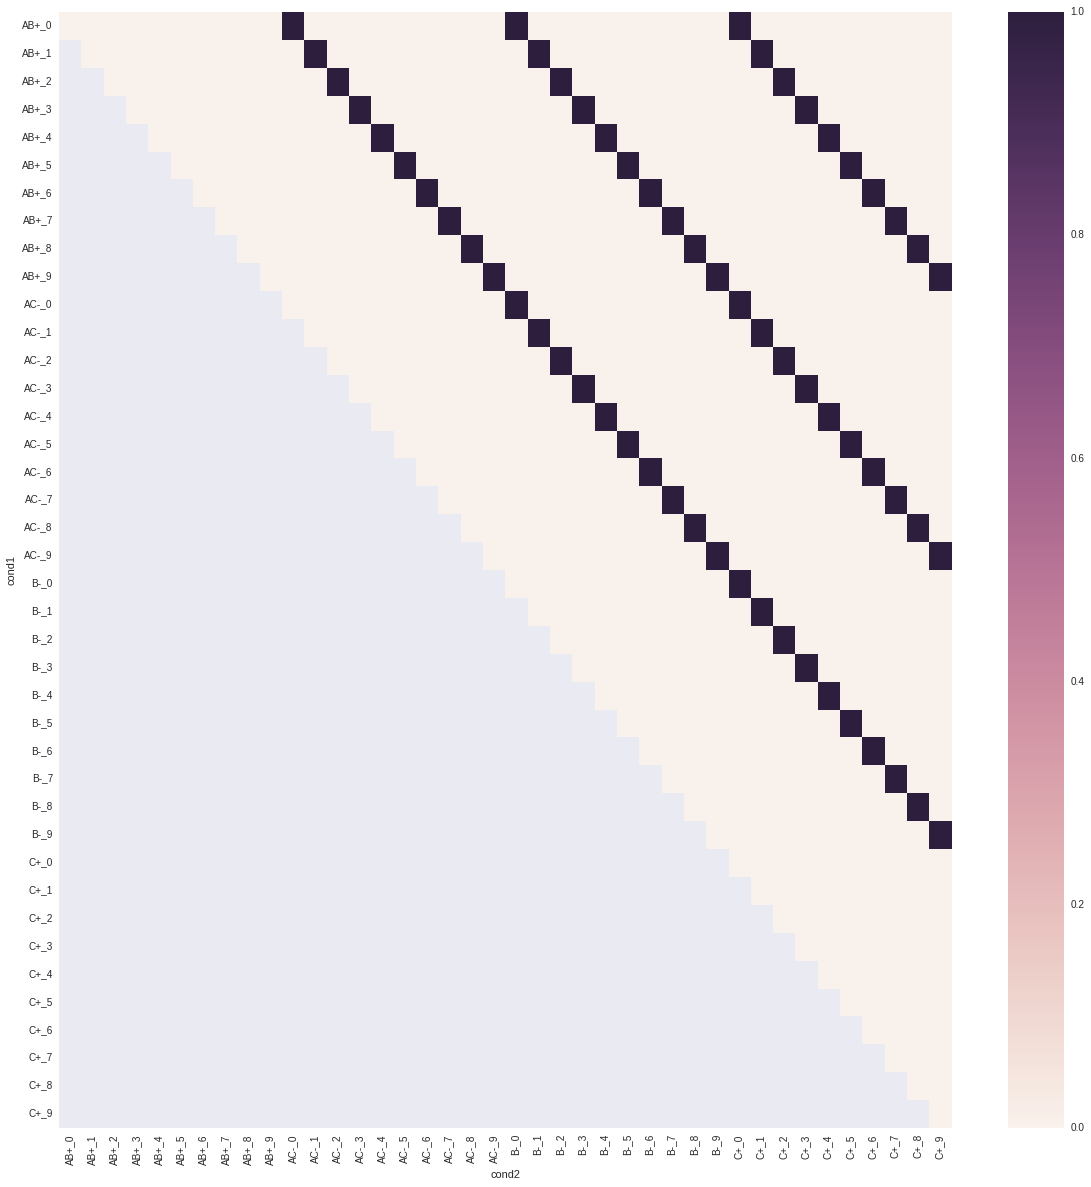

In [842]:
tmp  = mask_models['hipp']['fd_104'].copy()
tmp = tmp[tmp['run_idx'] ==1]

tmp['value'] = tmp['value']*-1
tmp['value'] = vector_reject(tmp['value'].values, tmp['response'].values)
# tmp['value'] = vector_reject(tmp['value'].values, tmp['valence'].values)

tmp['time0'] = map(int, tmp['time'] == 0)
x_var = 'time0'

tmp = tmp[['cond1','cond2',x_var]]
new_df = pd.DataFrame()
for cond in ['AB+_','B-_','AC-_','C+_']:
    for i in range(10):
        row = pd.DataFrame({x_var:0,
                            'cond1':cond + str(i),
                            'cond2':cond + str(i)},index = [0])
        new_df = new_df.append(row)
tmp = pd.concat([tmp,new_df])
tmp = tmp.groupby(['cond1','cond2']).mean().unstack()[x_var]
sns.heatmap(tmp)

In [808]:
#project a onto be
def vector_reject(a,b): #a gives variance to be
    return a - (np.dot(a,b)/np.dot(b,b)) * b
    

In [809]:
res = {'region':[],'sub':[], 'overlap':[], 'trial':[]}

for mask in masks:
    if mask != 'entorhinal':
        for sub in subs:
            m = mask_models[mask][sub].copy()

            m['value'] = scipy.stats.zscore(m['value'])
            m['valence'] = scipy.stats.zscore(m['valence'])
            m['response'] = scipy.stats.zscore(m['response'])
            
            for i in range(10):
                m['overlap_' + str(i)] = scipy.stats.zscore(m['overlap_' + str(i)])

            m['run_idx'] = map(str,m['run_idx'])
            m['corr'] = map(np.arctanh,m['corr'])

            model = ols("corr ~ value + identity + response + valence + run_idx + overlap_0 + overlap_1 + overlap_2 + overlap_3 +overlap_4 + overlap_5 + overlap_6 + overlap_7 +overlap_8 + overlap_9", m)    
#             model = ols("corr ~ run_idx + overlap_0 + overlap_1 + overlap_2 + overlap_3 +overlap_4 + overlap_5 + overlap_6 + overlap_7 +overlap_8 + overlap_9", m)    
            fit = model.fit()

            for i in range(10):
                res['overlap'].append(fit.params['overlap_' + str(i)])
                res['sub'].append(sub)
                res['region'].append(mask)
                res['trial'].append(i)
res = pd.DataFrame(res)

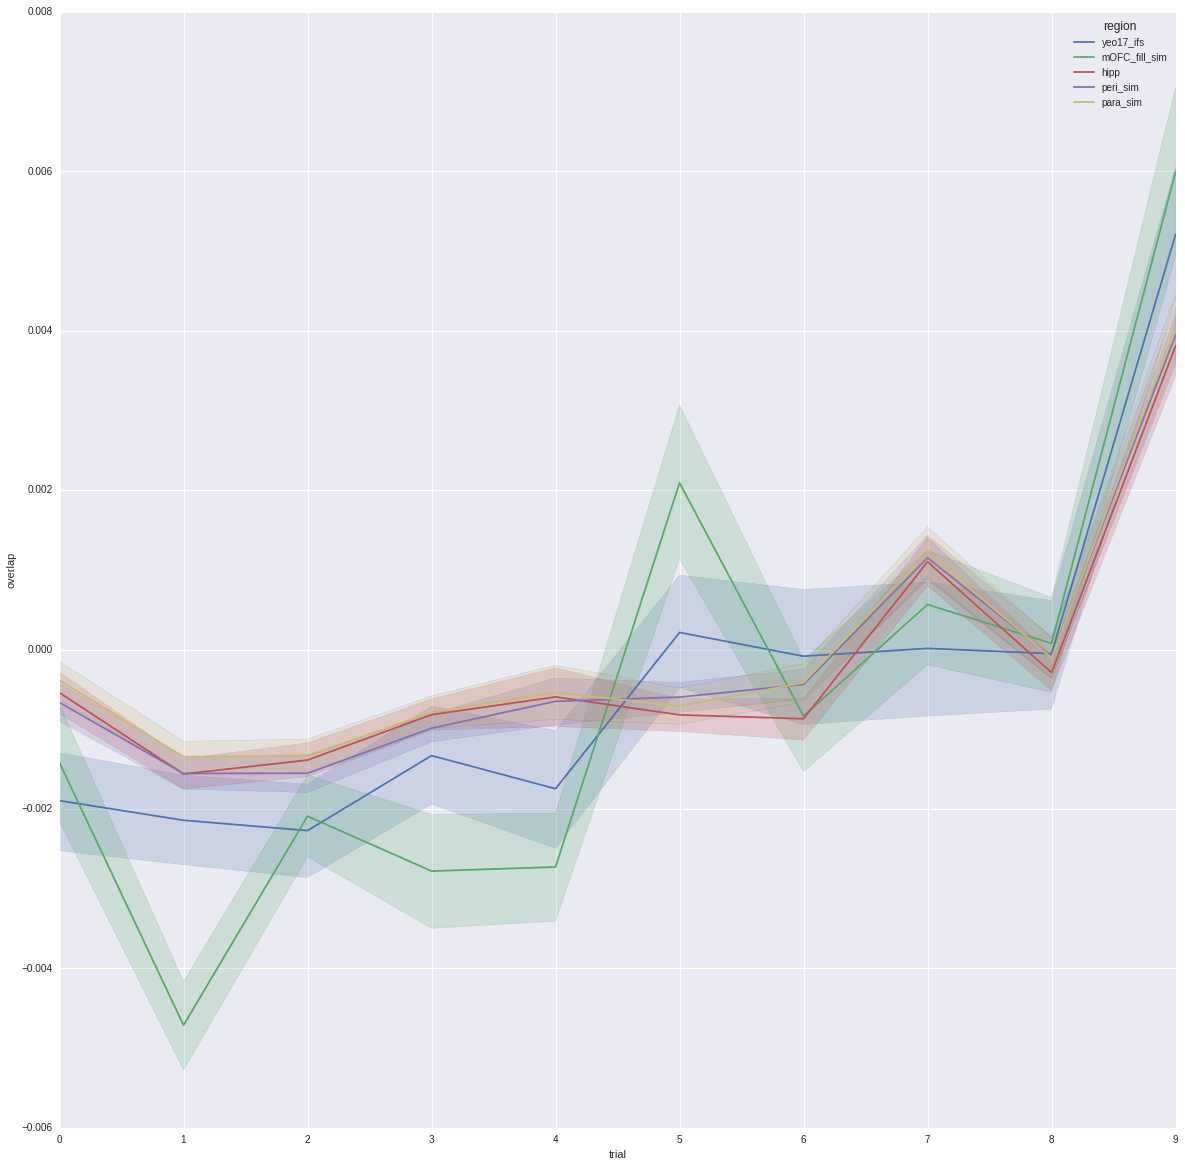

In [810]:
# sns.tsplot(res.groupby(['region','trial']).mean().loc['hipp']['overlap'].values)
# res.groupby(['region','trial']).loc['hipp']['overlap']
sns.tsplot(value = 'overlap',time = 'trial',unit = 'sub', condition = 'region', data = res)

In [843]:
res = {'intercept':[],'response':[],'valence':[],'overlap':[],'pe':[],'time:pe':[],
       'time':[],'value':[],'time:value':[],'time:overlap':[],'context':[],
       'time:identity':[],'time:response':[],'time:valence':[],'identity:value':[],
       'identity':[],'region':[],'sub':[]}

for mask in masks:
    if True:#mask == 'hipp':
        for sub in subs:
            m = mask_models[mask][sub].copy()
            m['value'] = -1 * m['value']
#             m['value'] = vector_reject(m['value'].values, m['response'].values)
#             m['value'] = vector_reject(m['value'].values, m['valence'].values)

#             tmp = m['response'] + m['valence']
#             tmp_map = {2:1,1:-1,0:0}
#             m['valence'] = [tmp_map[x] for x in tmp]
#             m['response'] = m['response']*2 -1

            
            m['value'] = scipy.stats.zscore(m['value'])
            m['pe'] = scipy.stats.zscore(m['pe'])
            m['valence'] = scipy.stats.zscore(m['valence'])
            m['valence'] = vector_reject(m['valence'].values, m['value'].values)

            m['response'] = scipy.stats.zscore(m['response'])
            m['overlap'] = scipy.stats.zscore(m['overlap'])
            m['context'] = scipy.stats.zscore(m['context'])

#             for i in range(0,10):
#                 m['time' + str(i)] = map(int, m['time'] == i)
            m['time'] = scipy.stats.zscore(m['time'])
            m['time2'] = [x**2 for x in m['time']]
#             m['time3'] = [x**3 for x in m['time']]
#             m['time4'] = [x**4 for x in m['time']]

            m['run_idx'] = map(str,m['run_idx'])
#             m['corr'] = 1 - m['corr']
            m['corr'] = map(np.arctanh,m['corr'])

            model = ols("corr ~ response + valence + run_idx + time*value + time*pe + time*identity  + time*context + time2", m)    
#             model = ols("corr ~ run_idx + time + time0 +time1 + time2 + time3 + time4 + time5 + time6 +time7 +time8 +time9", m)    
            fit = model.fit()
            mask_models[mask][sub]['resid'] = list(fit.resid)

            res['intercept'].append(fit.params['Intercept'])
            res['response'].append(fit.params['response'])
            res['valence'].append(fit.params['valence'])
            res['overlap'].append(0)#fit.params['overlap'])
            res['identity'].append(fit.params['identity'])
            res['time'].append(fit.params['time'])
            res['value'].append(fit.params['value'])
            res['context'].append(fit.params['context'])
            res['pe'].append(fit.params['pe'])
            res['time:pe'].append(fit.params['time:pe'])
            res['time:value'].append(fit.params['time:value'])
            res['time:overlap'].append(0)#fit.params['time:overlap'])
            res['time:identity'].append(fit.params['time:identity'])
            res['identity:value'].append(0)#fit.params['identity:value'])
            res['time:response'].append(0)#fit.params['time:response'])
            res['time:valence'].append(0)#fit.params['time:valence'])
            res['sub'].append(sub)
            res['region'].append(mask)

res = pd.DataFrame(res)

In [821]:
# resid_df = []
# for sub in subs:
#     tmp = mask_models['hipp'][sub][['cond1','cond2','run_idx','resid']]
#     tmp['sub'] = sub
#     resid_df.append(tmp.copy())
# resid_df = pd.concat(resid_df)

# new_df = pd.DataFrame()
# for run_idx in range(1,4):
#     for cond in ['AB+_','B-_','AC-_','C+_']:
#         for i in range(10):
#             row = pd.DataFrame({'resid':0,
#                                 'run_idx':run,
#                                 'cond1':cond + str(i),
#                                 'cond2':cond + str(i)},index = [0])
#             new_df = new_df.append(row)
# resid_df = pd.concat([resid_df,new_df])



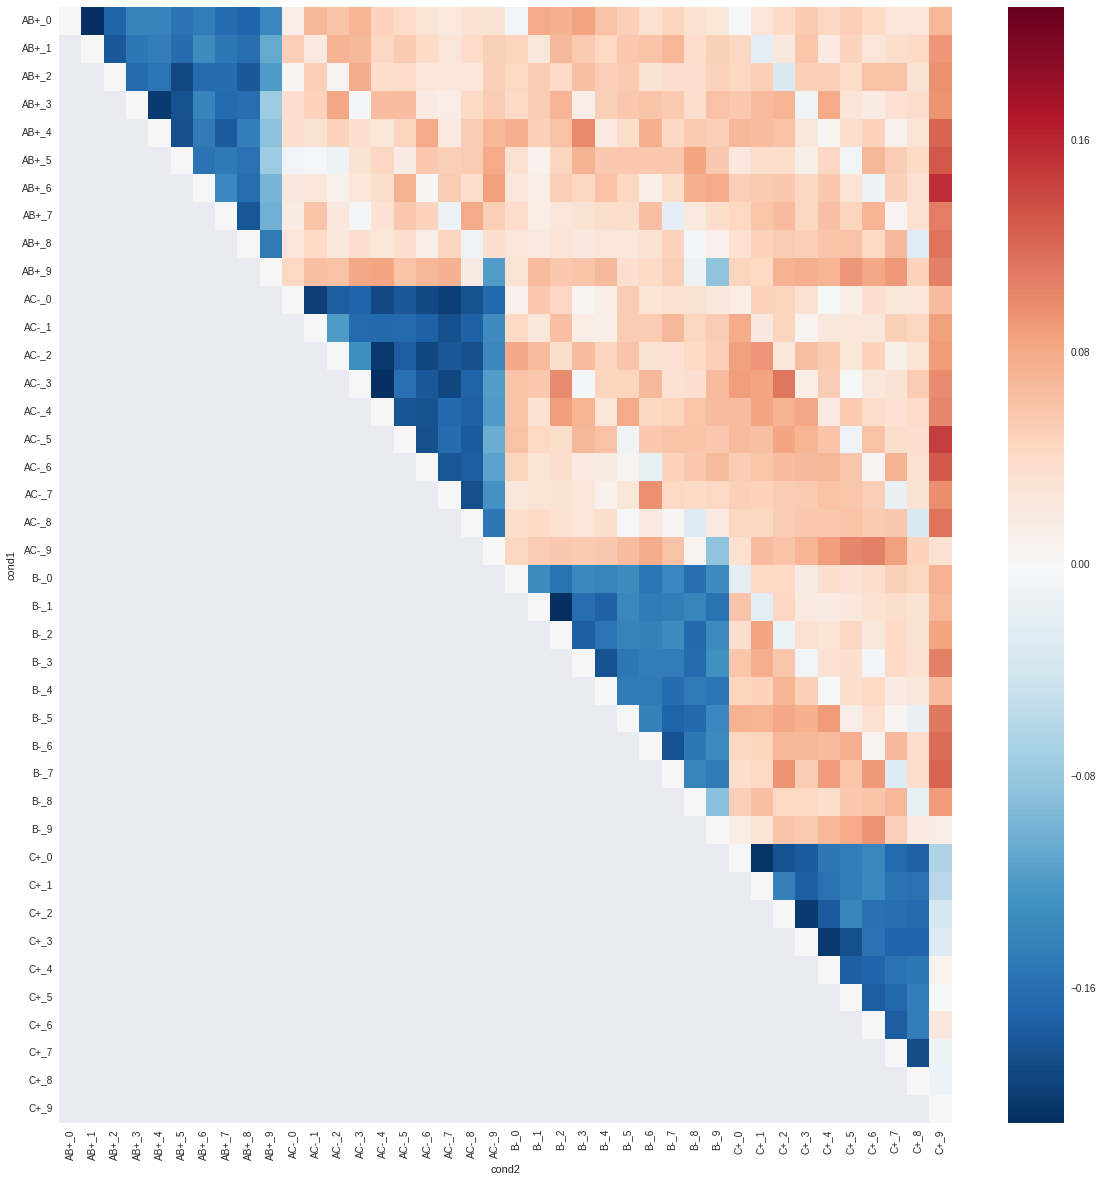

In [813]:
# print resid_df[resid_df['run_id']]
mean_rsa = resid_df.groupby(['cond1','cond2']).mean()
mean_rsa = mean_rsa.unstack()['resid']
sns.heatmap(mean_rsa)

In [814]:
# res = {'response':[],'valence':[],'overlap':[],
#        'time':[],'value':[],'time:value':[],'time:overlap':[],'context':[],
#        'time:identity':[],'time:response':[],'time:valence':[],'identity:value':[],
#        'identity':[],'region':[],'sub':[]}
# for pair in pairs:
#     res[pair] = []
    
# for mask in ['hipp']:
#     for sub in subs:
#         m = mask_models[mask][sub].copy()
#         m['value'] = -1 * m['value']


#         m['value'] = scipy.stats.zscore(m['value'])
#         m['valence'] = scipy.stats.zscore(m['valence'])
#         m['identity'] = scipy.stats.zscore(m['identity'])
#         m['response'] = scipy.stats.zscore(m['response'])

#         m['time'] = -1*m['time'] + 9
#         m['time'] = scipy.stats.zscore(m['time'])
#         m['time2'] = [x**2 for x in m['time']]

#         m['run_idx'] = map(str,m['run_idx'])
#         m['corr'] = map(np.arctanh,m['corr'])

#         model = ols("corr ~ -1 + response + valence + run_idx + time*value  + time*identity + time2 + b_pluszzzc_minus + b_pluszzzb_minus + c_pluszzzc_minus + c_pluszzzb_minus + c_pluszzzb_plus + b_minuszzzc_minus",
#                     m,)    
#         fit = model.fit()

#         for pair in pairs:
#             res[pair].append(fit.params[pair])
#         res['response'].append(fit.params['response'])
#         res['valence'].append(fit.params['valence'])
#         res['overlap'].append(0)#fit.params['overlap'])
#         res['identity'].append(fit.params['identity'])
#         res['time'].append(fit.params['time'])
#         res['value'].append(fit.params['value'])
#         res['context'].append(0)#fit.params['context'])
#         res['time:value'].append(fit.params['time:value'])
#         res['time:overlap'].append(0)#fit.params['time:overlap'])
#         res['time:identity'].append(fit.params['time:identity'])
#         res['identity:value'].append(0)#fit.params['identity:value'])
#         res['time:response'].append(0)#fit.params['time:response'])
#         res['time:valence'].append(0)#fit.params['time:valence'])
#         res['sub'].append(sub)
#         res['region'].append(mask)

# res = pd.DataFrame(res)

In [815]:
# model = patsy.dmatrices("corr ~ time*value + response + valence + overlap + time*identity + run_idx", m)

In [838]:
# print scipy.stats.ttest_1samp(res['time:value'].values,0)
# res.mean()
##value is higher for closer together
#value:time is higher for closer together and closer in time
scipy.stats.ttest_1samp(res.loc[res['region'] == 'yeo17_ifs','pe'].values,
                        0)
# res.loc[res['region'] == 'mOFC_fill_sim','overlap'].values

Ttest_1sampResult(statistic=3.5457280646963834, pvalue=0.0012674187235081525)

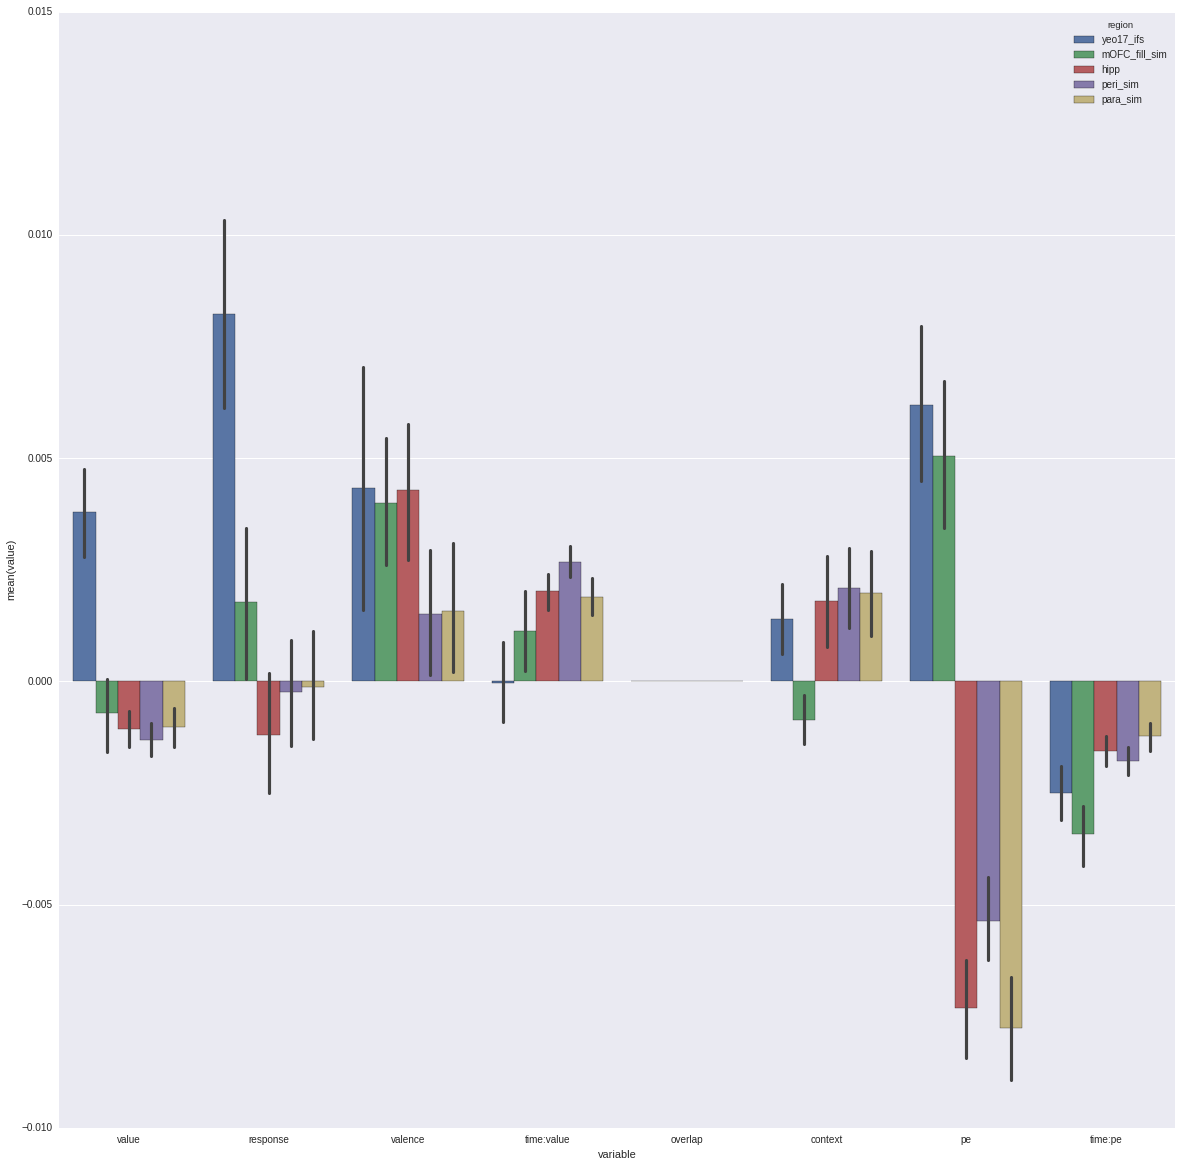

In [834]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=['value','response','valence','value',
                                                       'time:value','overlap','context','pe','time:pe'
                                                       ])
# res_melt = pd.melt(res, id_vars=['region'], value_vars=pairs)

sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)
plt.savefig('/home/iballard/Dropbox/fd/figs/value_RSA.png')

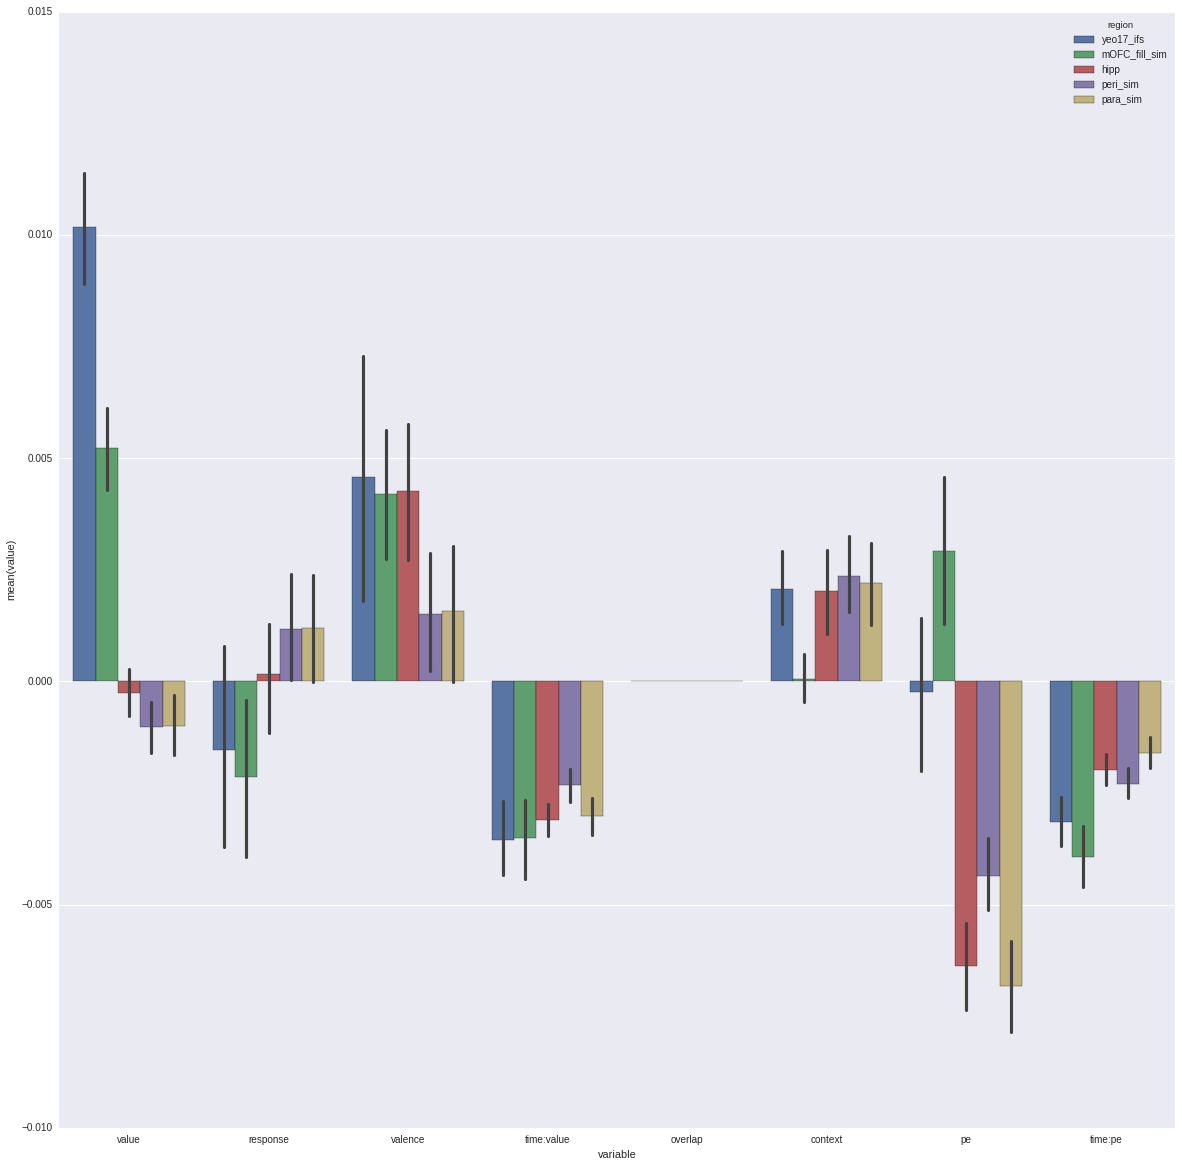

In [844]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=['value','response','valence','value',
                                                       'time:value','overlap','context','pe','time:pe'
                                                       ])
# res_melt = pd.melt(res, id_vars=['region'], value_vars=pairs)

sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)
plt.savefig('/home/iballard/Dropbox/fd/figs/value_RSA.png')

In [633]:
# # # m = mask_models[mask][sub].copy()
# mds_rsas = []
# for run in range(1,4):
#     mean_rsa = fig_rsas.loc['para_sim',1].groupby(['cond1','cond2']).mean()
#     mean_rsa = mean_rsa.unstack()['corr']
#     mean_rsa = 1 - mean_rsa

#     # pos = mds.fit(mean_rsa)
#     for c1 in mean_rsa.index.values:
#         for c2 in mean_rsa.index.values:
#             if np.isnan(mean_rsa[c1][c2]):
#                 mean_rsa[c1][c2] = mean_rsa[c2][c1]
#     mds_rsas.append(mean_rsa.values) 
    
# mds_rsas = np.mean(mds_rsas,0)
# # mds = manifold.MDS(metric = True, n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=-1, n_init = 1000)
# # pos = mds.fit_transform(mds_rsas)

# # # Rotate the data
# # clf = PCA(n_components=2)
# # pos = clf.fit_transform(pos)

In [702]:
run1 = resid_df[resid_df['run_idx'] == 2]
mean_rsa = resid_df.groupby(['cond1','cond2']).mean()['resid'].unstack()
for c1 in mean_rsa.index.values:
    for c2 in mean_rsa.index.values:
        if c1 == c2:
            mean_rsa[c1][c2] = 0
        if np.isnan(mean_rsa[c1][c2]):
            mean_rsa[c1][c2] = mean_rsa[c2][c1]

mds = manifold.MDS(metric = True, n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=-1, n_init = 1000)
pos = mds.fit_transform(mean_rsa)

# Rotate the data
clf = PCA(n_components=2)
pos = clf.fit_transform(pos)

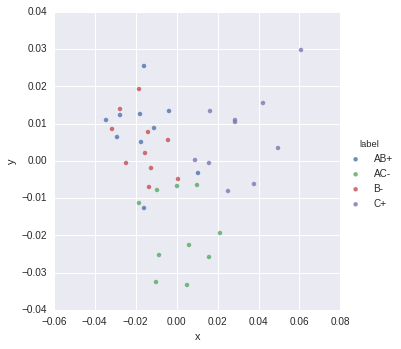

In [703]:
label = [x.split('_')[0] for x in mean_rsa.index.values]
results = pd.DataFrame({'x':pos[:,0],'y':pos[:,1],'label' :label})
sns.lmplot('x','y', hue = 'label', fit_reg = False, data = results)

In [706]:
# RL_std.loc[1]
labels = mean_rsa.index.values
Vs = []
for l in labels:
    c,n = l.split('_')
    V = RL_std.loc[(1,reverse_name_map[c]),'V'].values[n]
    Vs.append(str(round(V,2)))

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


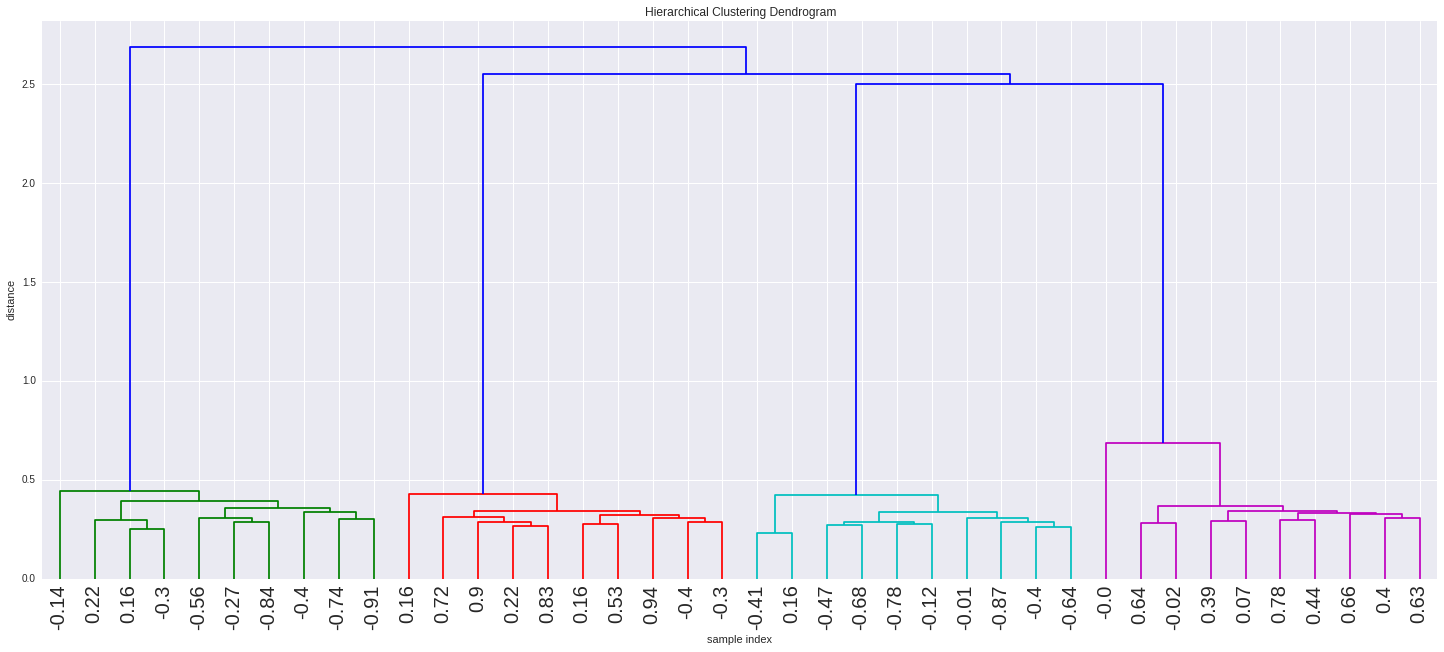

In [707]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(mean_rsa.values, 'ward')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    labels = Vs,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

In [128]:
rois= ['hipp','peri_sim','para_sim','entorhinal']
# rois= ['hipp']

res = {'intercept':[],'response':[],'valence':[],'overlap':[],'identity':[],'region':[],'sub':[]}
res_stacked = {'beta':[],'regressor':[],'region':[]}
for roi in rois:
    for sub,rsa in enumerate(all_rsas[roi]):
        data = pd.DataFrame()
        data['y'] = rsa[np.tril_indices_from(rsa)]
#         data['y'] = 1-rsa[np.tril_indices_from(rsa)]
        data['y'] = np.arctanh(data['y'])

        data['response'] = [1,0,1,0,1,1,1,0,0,1]
        data['valence'] = [1,0,-1,0,-1,-1,1,0,0,1]
        data['overlap'] = [0,1,0,1,0,0,0,1,0,0]
        data['identity'] = [1,0,1,0,0,1,0,0,0,1]
        data['double'] = [1,1,1,0,0,0,0,0,0,0]

        data['response'] = data['response'] - np.mean(data['response'])
        data['valence'] = data['valence'] - np.mean(data['valence'])
        data['overlap'] = data['overlap'] - np.mean(data['overlap'])
        data['identity'] = data['identity'] - np.mean(data['identity'])

        model = ols("y ~ identity + response + valence + overlap", data)    
        fit = model.fit()
        
        res['intercept'].append(fit.params['Intercept'])
        res['response'].append(fit.params['response'])
        res['valence'].append(fit.params['valence'])
        res['overlap'].append(fit.params['overlap'])
        res['identity'].append(fit.params['identity'])
        res['sub'].append(sub)
        res['region'].append(roi)
    
res = pd.DataFrame(res)
# res.to_csv('/home/iballard/Dropbox/fd/sim_similarity.csv')

In [129]:
# # rois= ['hipp','peri_sim','para_sim','entorhinal']
# rois= ['hipp']

# res = {'intercept':[],'response':[],'valence':[],'overlap':[],'region':[],'sub':[]}
# res_stacked = {'beta':[],'regressor':[],'region':[]}
# for roi in rois:
#     for sub,rsa in enumerate(all_rsas[roi]):
#         data = pd.DataFrame()
#         y = rsa[np.tril_indices_from(rsa)]
#         diag = [False,True,False,True,True,False,True,True,True,False]
#         data['y'] = [x for n,x in enumerate(y) if diag[n]]
        
#         data['response'] = [0,0,1,1,0,0]
#         data['valence'] = [0,0,-1,1,0,0]
#         data['overlap'] = [1,1,0,0,1,0]
# #         data['double'] = [1,1,1,0,0,0,0,0,0,0]


#         data['overlap'] = data['overlap'] - np.mean(data['overlap'])
#         model = ols("y ~  response + valence + overlap", data)    
#         fit = model.fit()
        
#         res['intercept'].append(fit.params['Intercept'])
#         res['response'].append(fit.params['response'])
#         res['valence'].append(fit.params['valence'])
#         res['overlap'].append(fit.params['overlap'])
#         res['sub'].append(sub)
#         res['region'].append(roi)
    
# res = pd.DataFrame(res)
# # res.to_csv('/home/iballard/Dropbox/fd/sim_similarity.csv')

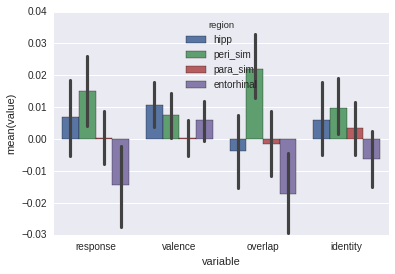

In [131]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=['response','valence','overlap','identity'])
sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)
# plt.savefig('/home/iballard/Dropbox/fd/RSA.png')